# Speech Emotion Recognition
In order to import our data set to colaboratory, we need to: 
- Run a set of commands to make sure Kaggle is installed
- Make a directory 
- Upload the API file kaggle.json (this has to be downloaded by creating a profile on kaggle and uploading it to the runtime
- Give permissions 
- Download the data set 
- Unzip that data set



In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

In [ ]:
! unzip /content/ravdess-emotional-speech-audio.zip

In [ ]:
! pip install tensorflow

# RAVDESS Dataset
The employed dataset is the RAVDESS dataset provided on [Kaggle](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio).

*   Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
*   Vocal channel (01 = speech, 02 = song).
*   Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*   Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
*   Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
*   Repetition (01 = 1st repetition, 02 = 2nd repetition).
*   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

*Example file: 03-01-08-01-01-02-11.wav*

1.   Audio-only (03)
2.   Speech (01)
3.   Surprised (08)
4.   Normal (01)
5.   Statement "Kids" (01)
6.   2nd Repetition (02)
7.   Actor 11 (11)
     Male, as the ID is odd.

# Importing libraries

In [ ]:
# Libraries used for Data Analysis
import pandas as pd
import numpy as np

# Libraries used to navigate, manipulate and use data in the operating file system
import os
import sys

# Librosa lets us use Python for extracting and analysing data from audio files
import librosa
import librosa.display

# Seaborn and matplotlib are libraries used for plotting data into informative graphs
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn is a library used to perform machine learning processes 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# IPython is a Jupyter based library which we use to play audio in the notebook
import IPython.display as ipd

# TensorFlow is the platform that opens possibilites for end-to-end machine learning, Keras is the framework used 
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import warnings
if not sys.warnoptions:
  warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Preparing the dataset

In [ ]:
#Making sure we can access the dataset directory 
#Setting the path to the speech only directory of the RAVDESS dataset
RAVDESS = "/content/audio_speech_actors_01-24/"
dlist = os.listdir(RAVDESS)
dlist.sort()

#Function to sort data from the data set
def load_data(data_set, dlist):
    #Creating two empty lists representing our emotion and feature
    emotion, file_path = [], []
    #Looping through the directory
    for i in dlist:
      fname = os.listdir(data_set + i)
      for file in fname:
        # Splitting the string to read the identifiers from the file name
        part = file.split('.')[0].split('-')
        # The documentation indicates the third index of a file represents the emotion
        emotion.append(int(part[2])) 
        file_path.append(data_set + i + '/' + file)
    return emotion, file_path

# Calling the function to fill the lists
emotion, path = load_data(RAVDESS, dlist)

# Concatenating the lists into a shared data frame with labeled columns
RAVDESS_df = pd.concat([pd.DataFrame(emotion), pd.DataFrame(path)], axis=1)
RAVDESS_df = RAVDESS_df.replace({ # Replacing the integer representations with strings
  1:'neutral', 
  2:'calm', 
  3:'happy', 
  4:'sad', 
  5:'angry', 
  6:'fearful', 
  7:'disgusted', 
  8:'surprised'})
RAVDESS_df.columns =  ['Emotion', 'Path'] # Label the columns

# Create a copy of the dataframe to convert to .csv 
data_path = RAVDESS_df
data_path.to_csv("data_path.csv",index=False)
data_path # Check if the content is unaltered in the notebook

,Emotion,Path
0,disgusted,/content/audio_speech_actors_01-24/Actor_01/03...
1,fearful,/content/audio_speech_actors_01-24/Actor_01/03...
2,surprised,/content/audio_speech_actors_01-24/Actor_01/03...
3,happy,/content/audio_speech_actors_01-24/Actor_01/03...
4,angry,/content/audio_speech_actors_01-24/Actor_01/03...
...,...,...
1435,happy,/content/audio_speech_actors_01-24/Actor_24/03...
1436,disgusted,/content/audio_speech_actors_01-24/Actor_24/03...
1437,fearful,/content/audio_speech_actors_01-24/Actor_24/03...
1438,surprised,/content/audio_speech_actors_01-24/Actor_24/03...


#Visualising the data

In order to implement and apply our deep neural network, we need to visualise it in a format that can be recognized by the architecture. 

Prior to the visualisation, we make sure the audio is playable in the notebook, to crosscheck with the dataframe
*   **Waveplots** are used to visualise the audio levels or loudness through time in the file
*   **Spectrograms** are used to visualise a spectrum of frequencies of time from an audio signal



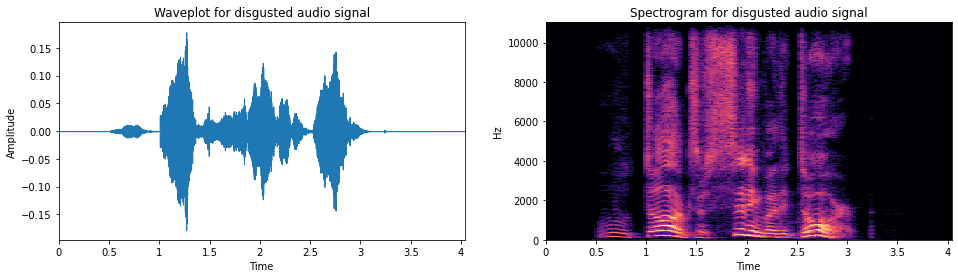

In [ ]:
# Choosing one audio file that will be used for examples in the notebook
emotion = 'disgusted'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sr = librosa.load(path)

# Function for display waveplot along with spectrogram
def plot_audio(data, sr, emotion):
  fig, ax = plt.subplots(1, 2, figsize=(16,4)) # 1 row, 2 columns subplots
  
  librosa.display.waveplot(data, sr=sr, ax=ax[0])
  ax[0].set(title='Waveplot for {} audio signal'.format(emotion))
  ax[0].set_ylabel('Amplitude')
  # Fourier transform for displaying spectrogram
  stft = np.abs(librosa.stft(data))
  spec = librosa.display.specshow(librosa.amplitude_to_db(stft), y_axis='hz', x_axis='time', ax=ax[1])
  ax[1].set(title='Spectrogram for {} audio signal'.format(emotion))

plot_audio(data, sr, emotion)
ipd.Audio(path) #Making the audio playable in the notebook

# Data Augmentation
To further increase the size of the data set and decreasing regularization error, we define four types of data augmentation.

In [ ]:
# Creating a function adding white noise to the signal
def add_noise(data, noise_rate):
    noise = np.random.normal(0, data.std(), data.size)
    augmented_data = data + noise * noise_rate
    return augmented_data

# Creating a function stretching the waveform
def time_stretch(data, stretch):
    return librosa.effects.time_stretch(data, stretch)

#Function for time shifting
def time_shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5)*1000)
    return np.roll(data, shift_range)

#Function for pitch changing
def scale_pitch(data, sampling_rate, pitch):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch)

# Feature Extraction

Before creating a funtion to extract all desired features at once, we create test on file to extract spectrograms for each feature and give visual proof 

[Text(0.5, 1.0, 'Mel Spectrogram for disgusted emotion + noise')]

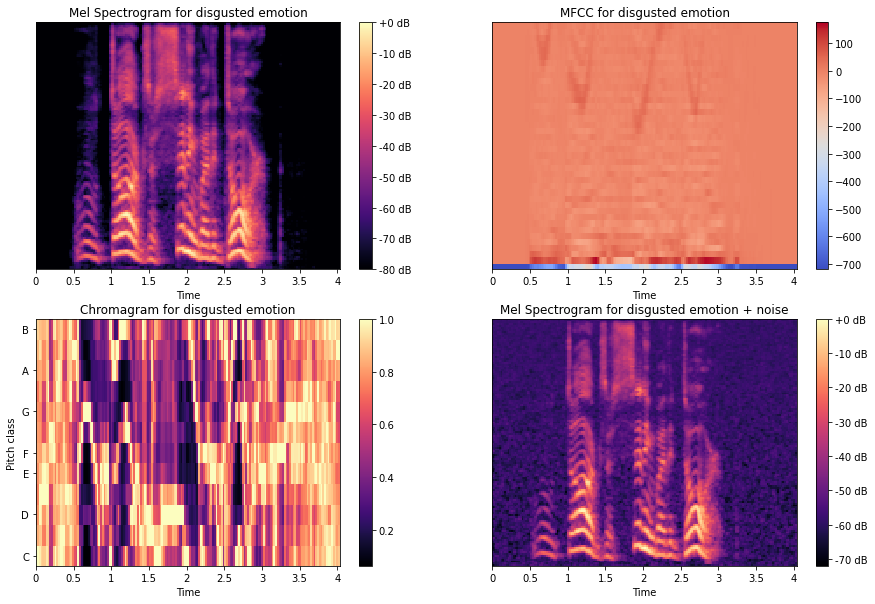

In [ ]:
'''
  Continuing with the previous example, we create subplots containing
  examples of features and augmentation to show the visual change
'''

# Setting up a figure with 4 axes in a 2x2 grid.
fig, ax = plt.subplots(2,2, figsize=(15,10))

# Visualing Mel Spectrogram
mel = librosa.feature.melspectrogram(y=data, sr=sr)
mel_dB = librosa.power_to_db(mel, ref=np.max)
img = librosa.display.specshow(mel_dB, x_axis='time', ax=ax[0,0])
fig.colorbar(img, ax=ax[0,0], format='%+2.0f dB')
ax[0,0].set(title='Mel Spectrogram for {} emotion'.format(emotion))

# Visualising MFCC
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40)
img = librosa.display.specshow(mfcc, x_axis='time', ax=ax[0,1])
fig.colorbar(img, ax=ax[0,1])
ax[0,1].set(title='MFCC for {} emotion'.format(emotion))

# Visualing Chroma STFT
stft = np.abs(librosa.stft(data))
chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
img = librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time', ax=ax[1,0])
fig.colorbar(img, ax=ax[1,0])
ax[1,0].set(title='Chromagram for {} emotion'.format(emotion))

# Visualising noise augmentation data in mel spectrogram
mel_noise = librosa.feature.melspectrogram(y=add_noise(data, 0.05), sr=sr)
mel_dB_noise = librosa.power_to_db(mel_noise, ref=np.max)
img = librosa.display.specshow(mel_dB_noise, x_axis='time', ax=ax[1,1])
fig.colorbar(img, ax=ax[1,1], format='%+2.0f dB')
ax[1,1].set(title='Mel Spectrogram for {} emotion + noise'.format(emotion))

In [ ]:
# Defining feature extraction functions
# returning the mean of the librosa functions and stacking the data horizontally

def extract_features(data):
  result = np.array([])

  # Zero Crossing Rate (ZCR)
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
  #result = np.hstack((result, zcr))

  # Chroma Short Fourier Transform (STFT)
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
  #result = np.hstack((result, chroma_stft)) 

  # Mel-frequency cepstrum coefficient (MFCC)
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr).T, axis=0)
  #result = np.hstack((result, mfcc))

  # Mel Spectogram
  melspec = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
  
  result = np.hstack((result, zcr))
  result = np.hstack((result, chroma_stft)) 
  result = np.hstack((result, mfcc))
  result = np.hstack((result, melspec))

  return result

In [ ]:
# Get features function
def get_features(path):
    data, sr = librosa.load(path, duration=2.5, offset=0.5)

    # Adding unaugmented data and creating a result array
    feature = extract_features(data)
    result = np.array(feature)

    # Adding noise augmentation
    noise_feature = add_noise(data, 0.05)
    feature_1 = extract_features(noise_feature)
    result = np.vstack((result, feature_1))

    # Adding time shift augmentation
    shift_feature = time_shift(data)
    feature_2 = extract_features(shift_feature)
    result = np.vstack((result, feature_2))

    # Adding pitch augmentation
    pitch_feature = scale_pitch(data, sr, 0.8)
    feature_3 = extract_features(pitch_feature)
    result = np.vstack((result, feature_3))

    # Adding noise + pitch augmentation
    noise_pitch_feature = add_noise(data, 0.05)
    noise_pitch_feature = scale_pitch(noise_pitch_feature, sr, 0.8)
    feature_4 = extract_features(noise_pitch_feature)
    result = np.vstack((result, feature_4))

    return result

#Making a loop to extract emotions for the extracted features
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotion):
    features = get_features(path)
    for feature in features:
      X.append(feature)
      Y.append(emotion)

# Creating a dataframe to contain our expanded dataset including features
features_df = pd.DataFrame(X)
features_df['labels'] = Y
features_df.to_csv('features.csv',index = False)
features_df.head()



```
# This is formatted as code
```

# Data preparation

In [ ]:
# TODO: CLEANUP AND INCREASE READABILITY - BETTER COMMENTING - (this is where I'm at currently)

#data preparation 
#we are now split the data for traning and testing 
#the funtion Features.iloc make it possiable to select a specific cell of the dataset

X = features_df.iloc[: ,:-1].values
Y = features_df['labels'].values

#multiclass classification for Y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

#splitting the data into test and traning set
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# scaling data with sklearn
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

#enable data's compareablity to data
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5400, 161, 1), (5400, 8), (1800, 161, 1), (1800, 8))

# The model

In [ ]:
# We set repeated values as variables before defining our model function
input_shape = (x_train.shape[1],1)

def build_model(training_data):
    model = Sequential(
        [
            Conv1D(256, kernel_size=5, strides = 1, padding='same',activation='relu',input_shape=input_shape),
            MaxPooling1D(pool_size=5,strides=2,padding='same'),

            Conv1D(256, kernel_size=5,strides=1,padding='same',activation='relu'),
            MaxPooling1D(pool_size=5,strides=2,padding='same'),
         
            Conv1D(128, kernel_size=5,strides=1,padding='same',activation='relu'),
            MaxPooling1D(pool_size=5,strides=2,padding='same'),
            Dropout(0.2),

            Conv1D(64, kernel_size=5,strides=1,padding='same',activation='relu'),
            MaxPooling1D(pool_size=5,strides=2,padding='same'),
            Flatten(),
            Dense(32, activation = 'relu'),
            Dropout(0.3),
            Dense(8, activation ='softmax')
        ]
    )

    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    
    return model

model = build_model(x_train)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_58 (Conv1D)          (None, 161, 256)          1536      
                                                                 
 max_pooling1d_58 (MaxPoolin  (None, 81, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_59 (Conv1D)          (None, 81, 256)           327936    
                                                                 
 max_pooling1d_59 (MaxPoolin  (None, 41, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_60 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_60 (MaxPoolin  (None, 21, 128)        

# Running the model

In [ ]:
# Defining values for monitors learning loss rate.
reduce_learning_rate = ReduceLROnPlateau(
    monitor='loss', # Monitoring the loss parameter
    factor = 0.4, # Learning rate reduction factor
    verbose = 0, # Disabling update messages
    patience = 2, # Amount of epochs with no improvement before reducing learning rate
    min_lr = 0.0000001 # Lower bound
)

# Training on the model
history = model.fit(
    x_train, # input data
    y_train, # target data
    batch_size=64, # number of samples per batch
    epochs=50, # number of iterations over x and y 
    validation_data=(x_test, y_test), # what data to evaluate loss upon
    callbacks=[reduce_learning_rate] # list of what callbacks to run
) 

# Results

In [ ]:
print("Accuracy of the model is : " , model.evaluate(x_test,y_test)[1]*100, "%")

epochs = list(range(50))
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs, train_loss , label='Training Loss')
ax[0].plot(epochs, test_loss , label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')

ax[1].plot(epochs , train_acc, label= 'Training Accuracy')
ax[1].plot(epochs , test_acc, label= 'Testing Accuracy')
ax[1].set_title('Training and Testing Accuracy')
ax[1].set_xlabel('Epochs')
plt.show()

#print("Accuracy of the model is : " , model.evaluate(x_test,y_test)[1]*100, "%")

In [ ]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)

,Predicted Labels,Actual Labels
0,calm,calm
1,angry,angry
2,happy,happy
3,disgusted,happy
4,sad,happy
5,calm,calm
6,happy,fearful
7,angry,angry
8,disgusted,disgusted
9,fearful,fearful


Making a confusion Matrix

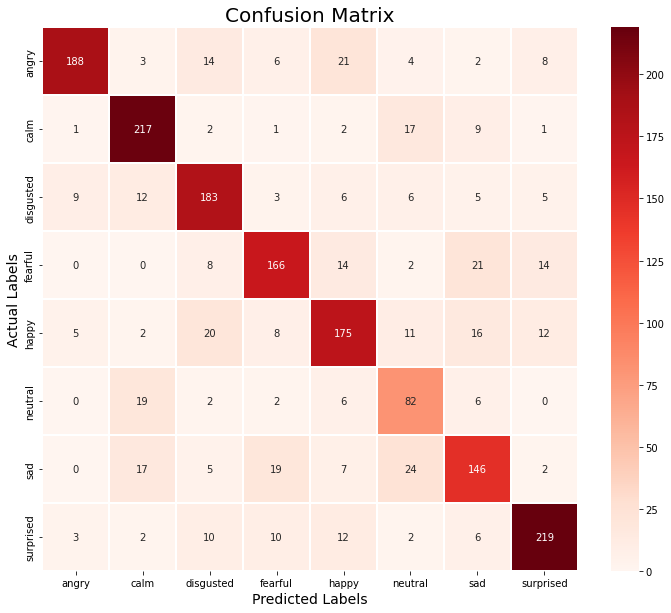

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm, index = [i for i in encoder.categories_], columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor ='white', cmap='Reds', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()